## changefinderによる異常検知
> ([【Day-22】データ分析技術で仮想通貨の暴騰・暴落を捉えられるか](https://www.procrasist.com/entry/22-changefinder)より一部抜粋)

>([【ターニングポイントを探せ！ 【change finderで時系列の変化点抽出】](https://qiita.com/deaikei/items/af728ab0d43ca97bc1f6)より一部抜粋)

### changefinderとは
- [データマイニングによる異常検知](http://www.amazon.co.jp/exec/obidos/ASIN/4320018826/imslotter04-22/)という著書に登場する，変化点を検知する技術のことである．

### 理論
1. ウィンドウ枠(窓枠)$k$で自己回帰モデル（ARモデル）を用意し，SDARアルゴリズム（忘却型アルゴリズム）で学習する．

1. 時刻$t-k$から$t-1$の値で，それ以降の時系列を予測するモデル$p_t$が完成する．
1.上記のARモデル$p_t-1$に対し，時刻$t$での異常値スコアを次式のように算出する．
$$Score(x_t) = - \ln(p_t-1)x_t$$
1. 幅Tのウィンドウ（窓）を設け，下式によりスコアの平均を計算する．
$$y_t=\frac{1}{T} \sum_{i=t-T+1}^{t} Score(x_t)$$
1. 平滑化された時系列データ$y_t$に対して，再度ARモデルを用意してSDARアルゴリズムで学習する.

1. 時刻$t-k$から$t-1$の値で，それ以降の時系列を予測するモデル$q_t$が完成する．

1. 幅$T'$のウィンドウを設け，下式によりスコアの平均を計算する．(=スムージング)
$$Score(x_t)=\frac{1}{T'} \sum_{i=t-T'+1}^{t} - \ln(q_t-1) y_t $$

### 環境構築
Anaconda(単にconda)やpip3などのPython用パッケージ管理ツールを導入する．これにより，changefinder以外に読み込むライブラリ(`scipy`,`numpy`,`datetime`,`pandas`,`matplotlib`など)が利用できる，

次に，コマンドライン（ターミナル等）にて

 ```$ pip3 install changefinder```

と打ち，changefinderライブラリを導入する．(※筆者の環境ではcondaとpip3の共存によりchangefinderを運用しているが，両者が競合しファイルが壊れる可能性が高いため非推奨である．)

[Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb?hl=ja)(Googleのオンライン開発環境)を利用する場合は，ソースコードの最初の行に

```!pip3 install changefinder```

と記述する必要がある．

### 主要パラメータについて
ソースコード中に

```changefinder.ChangeFinder(r=0.01, order=1, smooth=7)```

という関数がある．この関数のパラメータについて説明する．

 `r` :忘却パラメータ
 - 確率密度関数を算出する際，どの程度過去の影響をコントロールするかを示している．つまり，この値を小さくすると過去の影響が大きくなり，変化点のバラツキが大きくなる．


 `order` :時系列モデルの次数
- どこまで過去の値をモデルに組み込むかを設定する．


 `smooth` :外れ値スコアをスムージングするための区間長(=範囲)

- 長くするほど外れ値ではなく変化が捉えられる．しかし範囲が長すぎると変化が捉えづらくなる．


time:2020/4/8


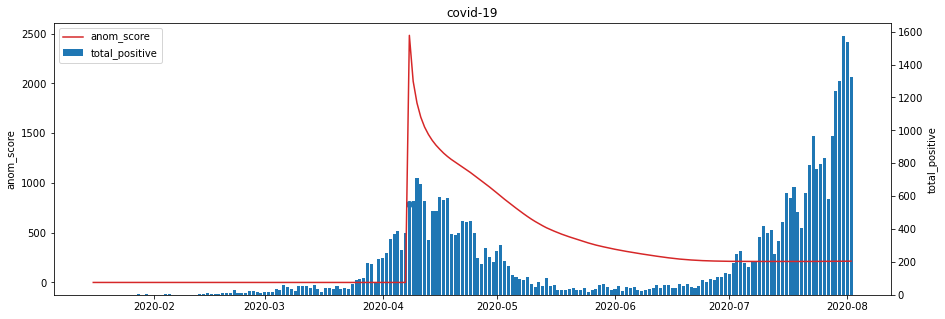

,Unnamed: 0,timestamp,positive,total_positive
timestamp,,,,
2020-01-16,0,2020/1/16,1,-1000.000000
2020-01-17,1,2020/1/17,0,-1000.000000
2020-01-18,2,2020/1/18,0,-1000.000000
2020-01-19,3,2020/1/19,0,-1000.000000
2020-01-20,4,2020/1/20,0,-1000.000000
...,...,...,...,...
2020-07-29,195,2020/7/29,1242,-787.747621
2020-07-30,196,2020/7/30,1297,-787.431124
2020-07-31,197,2020/7/31,1574,-787.037144


In [1]:
%matplotlib inline
#!pip3 install changefinder #Google Colab用(コメントを外して利用する)
import changefinder#$ pip3 install changefinder
import pandas as pd#データ分析用
from datetime import datetime as dt#日付・時間用
import matplotlib.pyplot as plt#グラフ用
import numpy as np#数値計算用

#文字列(str)を日付(datetime)に変換する関数
def str2datetime(tstr):
    if tstr.__class__.__name__ == "datetime":
        return tstr

    ts = tstr.split(".")[0] #__class__("datetimeのクラス")と__name__(そのクラス名)に分割する
    return dt.strptime(ts, "%Y/%m/%d") #yyyy/mm/ddの形式で日付に変換
    

#changefinder(cf)での計算を行う関数
def calc_cf(name, df, cf, threshold):
    values = df[name].values #name:取り出したい列の名前
    scores = np.array([cf.update(value) for value in values]) #列内の値をループして取り出す
    #print(scores) #cfでの計算結果を表示

    # 描画
    fig, ax1 = plt.subplots(figsize=(15,5))
    ax1.set_title("covid-19") #グラフタイトルにnameを表示する
    ax1.plot(df.index,scores,label="anom_score",color="tab:red") #赤のグラフがcfでの計算結果を示す
    ax1.set_ylabel("anom_score") #グラフのy軸に表示する

    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.bar(df.index, df[name].values,label="total_positive",color="tab:blue")
    ax2.set_ylabel("total_positive")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left')

    ax1.set_zorder(2) #anom_scoreを手前に設定
    ax1.set_frame_on(False)
    ax2.set_zorder(1) #total_positiveを奥に設定

    # しきい値越えリスト
    param="total_positive"

    df[param] = scores - threshold #(偏差)=(cfでの計算結果)-(しきい値)
    for i in range(1,len(df)):
        if df.iloc[i-1][param] < 0 and df.iloc[i][param] >= 0:
            print("time:{}".format(df.iloc[i]["timestamp"]))
            ax2.plot(df.index[i],df.iloc[i][name],"o")
    plt.show()
    return df

#r=0.00056~
cf = changefinder.ChangeFinder(r=0.001, order=1, smooth=55) #r:忘却パラメータ,order:時系列モデルの次数,smooth:スムージング範囲
df = pd.read_csv("pcr_positive_daily.csv",engine='c').dropna() #読み込むcsvファイルを指定する
df.index=df.timestamp.apply(str2datetime)
calc_cf(name="positive",df=df, cf=cf, threshold=1000)

